In [1]:
import os, random
import rasterio
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate

import numpy as np
import glob as gb
from matplotlib import pyplot as plt
from PIL import Image
from rasterio.plot import reshape_as_image

import albumentations as A
from albumentations.augmentations.geometric.resize import Resize

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [2]:
raster_path = 'original/T36UXV_20200406T083559_TCI_10m.jp2'

In [4]:
with rasterio.open(raster_path, 'r', driver='JP2OpenJPEG') as src:
    print (src.crs)
    raster_img = src.read()
    raster_meta = src.meta

EPSG:32636


In [5]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [6]:
mask_path = 'original/label.jp2'

In [7]:
with rasterio.open(mask_path, 'r', driver='JP2OpenJPEG') as src:
    print (src.crs)
    mask_img = src.read()
    mask_meta = src.meta

EPSG:32636


In [8]:
mask_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [9]:
raster_img = reshape_as_image(raster_img)
mask_img = reshape_as_image(mask_img)

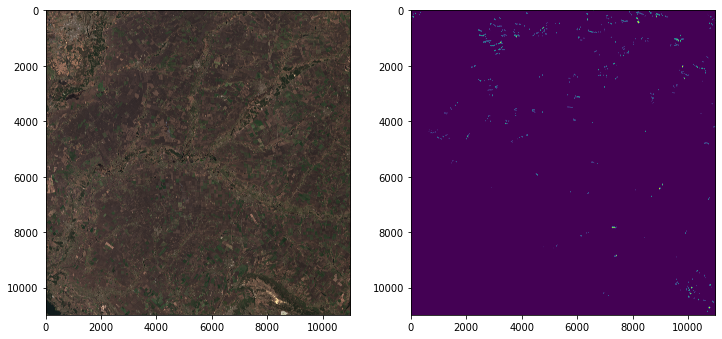

In [10]:
# Our image and mask to it
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(raster_img)
plt.subplot(122)
plt.imshow(mask_img)
plt.show()

In [11]:
label_seg = mask_img.copy()

In [12]:
label_seg.shape

(10980, 10980, 1)

Create label array, where `1 - for soil erosion`, `0 - normal`

In [13]:
# labeled mask by 0 and 1
label_seg = np.where(label_seg != 0, 1, 0)

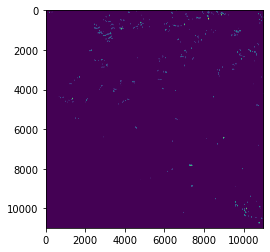

In [14]:
plt.imshow(label_seg.squeeze())

In [15]:
n_classes = len(np.unique(label_seg))

In [16]:
IMG_HEIGHT=raster_img.shape[0]
IMG_WIDTH=raster_img.shape[1]
IMG_CHANNELS = raster_img.shape[2]

# UNet

## Data Augmentation

In [17]:
# Resize to the size - power of 2(good for model)
IMG_RESIZE = 512

In [18]:
def augment(width, height):
    transforms = A.Compose([
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.GridDistortion(p=0.5),
        Resize(width, height, interpolation=cv2.INTER_NEAREST, always_apply=True)
    ], p=1.0)
    
    return transforms

In [19]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(20, 20), squeeze=True)
        f.set_tight_layout(h_pad=5, w_pad=5)
        
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
        plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=0.01)
        
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.jpg', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

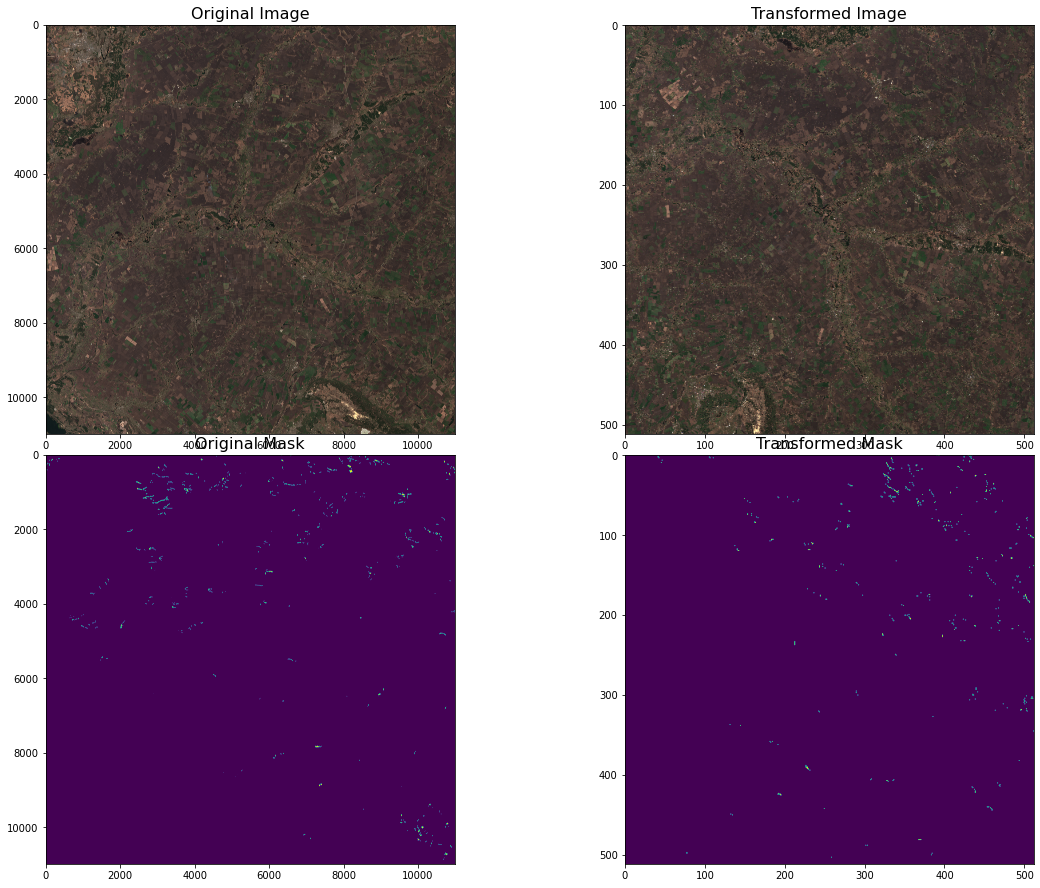

In [20]:
transform = augment(IMG_RESIZE, IMG_RESIZE)
transformed = transform(image=raster_img, mask=label_seg)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

visualize(transformed_image, transformed_mask, raster_img, label_seg)

## Saving Augmented Images to Disk

In [21]:
!mkdir augmented
!mkdir augmented/images
!mkdir augmented/masks

mkdir: cannot create directory ‘augmented’: File exists
mkdir: cannot create directory ‘augmented/images’: File exists
mkdir: cannot create directory ‘augmented/masks’: File exists


In [22]:
# Generate transformed images for increasing datasets
names = []
n_augs = 10
for i in range(n_augs):
    transform = augment(IMG_RESIZE, IMG_RESIZE)
    transformed = transform(image=raster_img, mask=label_seg)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
    name_img = 'augmented/images/tran_img_' + str(i) + '.jpg'
    name_mask = 'augmented/masks/tran_mask_' + str(i) + '.jpg'
    cv2.imwrite(name_img, transformed_image)
    cv2.imwrite(name_mask, transformed_mask)
    names.append((name_img, name_mask))

## Custom Image Data Generators 

In [23]:
img_dim = IMG_RESIZE

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
mask_datagen = ImageDataGenerator(validation_split=0.25)

train_image_generator = image_datagen.flow_from_directory(
        'augmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 1,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        'augmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 1,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        'augmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 1,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        'augmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 1,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 8 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [24]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

### Visualization

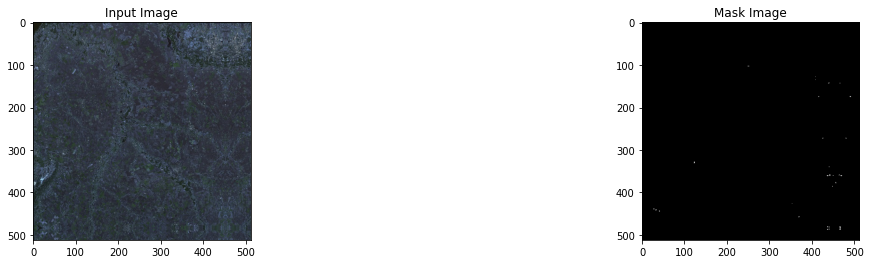

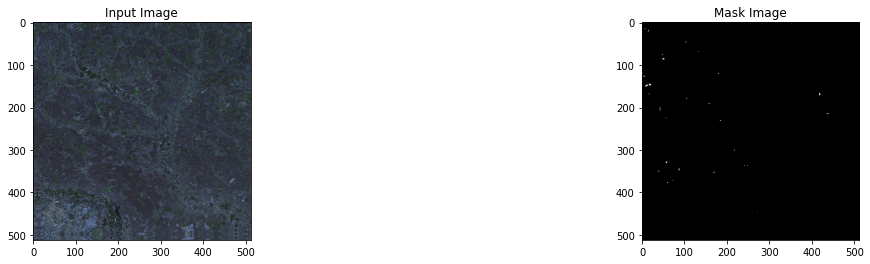

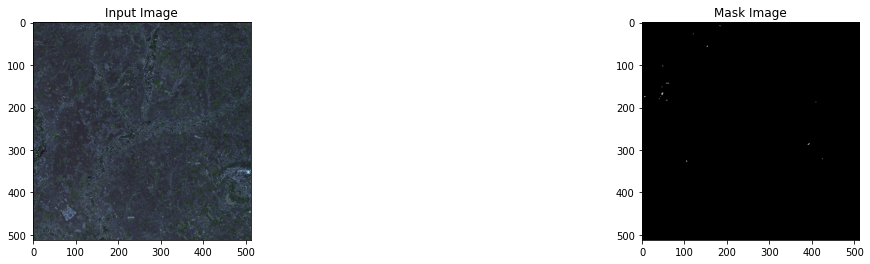

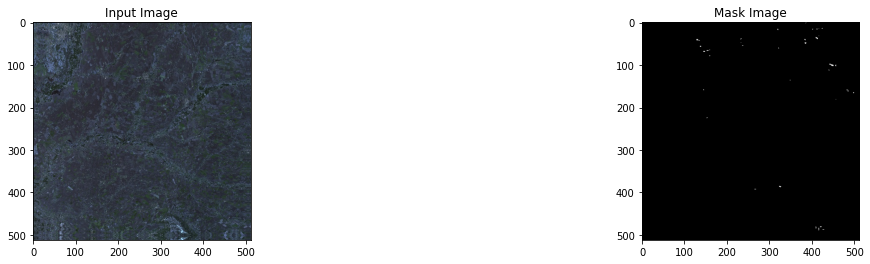

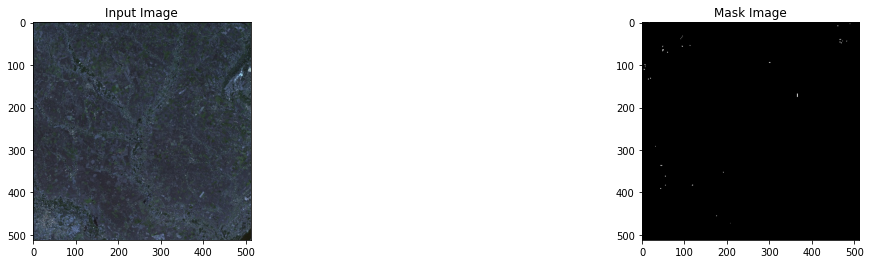

In [25]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

## Model

### UNet: Segmentation Architecture

* It is an encoder-decoder architecture that downsamples an image input using convolutional filters and identifies all the features of the image and then upsamples them by applying transpose convolutions on the downsampled feature maps concatenated with some feature maps from their encoder counterpart
* The original U-Net model did not have padding set as same in its convolutional blocks, therefore in the image it can be seen that the input is downsampled after each convolution operation.
* However, we will set padding as same for our model
* We have also changed the architecture slighlty by adding an additional block of convolutional layer, beginning with 32 filters block contrary to the 64 fitlers block in the original paper
* Since the feature maps in the encoder section will also consider some useful information we concatenate them with the output of the transpose convolution operation while upsampling so that it can use that information to predict the segmentation masks



In [27]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


### Added aditional metrics
Added iou because accuracy don't provide good enstatement of result (have acc 99, but mean result in one point) 

In [38]:
from keras import backend as K
# usin iou have too pessimistic variant of predictions, because of small area
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [68]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = ['binary_crossentropy'], 
              metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 512, 512, 32  896         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 512, 512, 32  128        ['conv2d_152[0][0]']             
 Normalization)                 )                                                             

In [69]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)


In [70]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//1,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//1,
                    epochs=10, callbacks=[earlystop, checkpoint])

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.8543
Epoch 1: val_loss improved from inf to 0.67629, saving model to unet.h5
8/8 [==============================] - 40s 5s/step - loss: 0.5144 - accuracy: 0.8543 - val_loss: 0.6763 - val_accuracy: 0.8158
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.9949
Epoch 2: val_loss did not improve from 0.67629
8/8 [==============================] - 41s 5s/step - loss: 0.2905 - accuracy: 0.9949 - val_loss: 1.1923 - val_accuracy: 0.4678
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9977
Epoch 3: val_loss improved from 0.67629 to 0.63927, saving model to unet.h5
8/8 [==============================] - 41s 5s/step - loss: 0.2190 - accuracy: 0.9977 - val_loss: 0.6393 - val_accuracy: 0.8779
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9988
Epoch 4: val_loss did not improve from 0.63927
8/8 [====

## Inferencing

In [71]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 1s 1s/step


In [72]:
predicted_masks.shape

(1, 512, 512, 1)

### Ground Truth Masks vs Predicted Masks

In [73]:
val_image_samples = np.squeeze(val_image_samples, axis=0)
val_mask_samples = np.squeeze(val_mask_samples, axis=0)
predicted_masks = np.squeeze(predicted_masks, axis=0)

In [74]:
sum(sum(predicted_masks))

array([12.], dtype=float32)

(-0.5, 511.5, 511.5, -0.5)

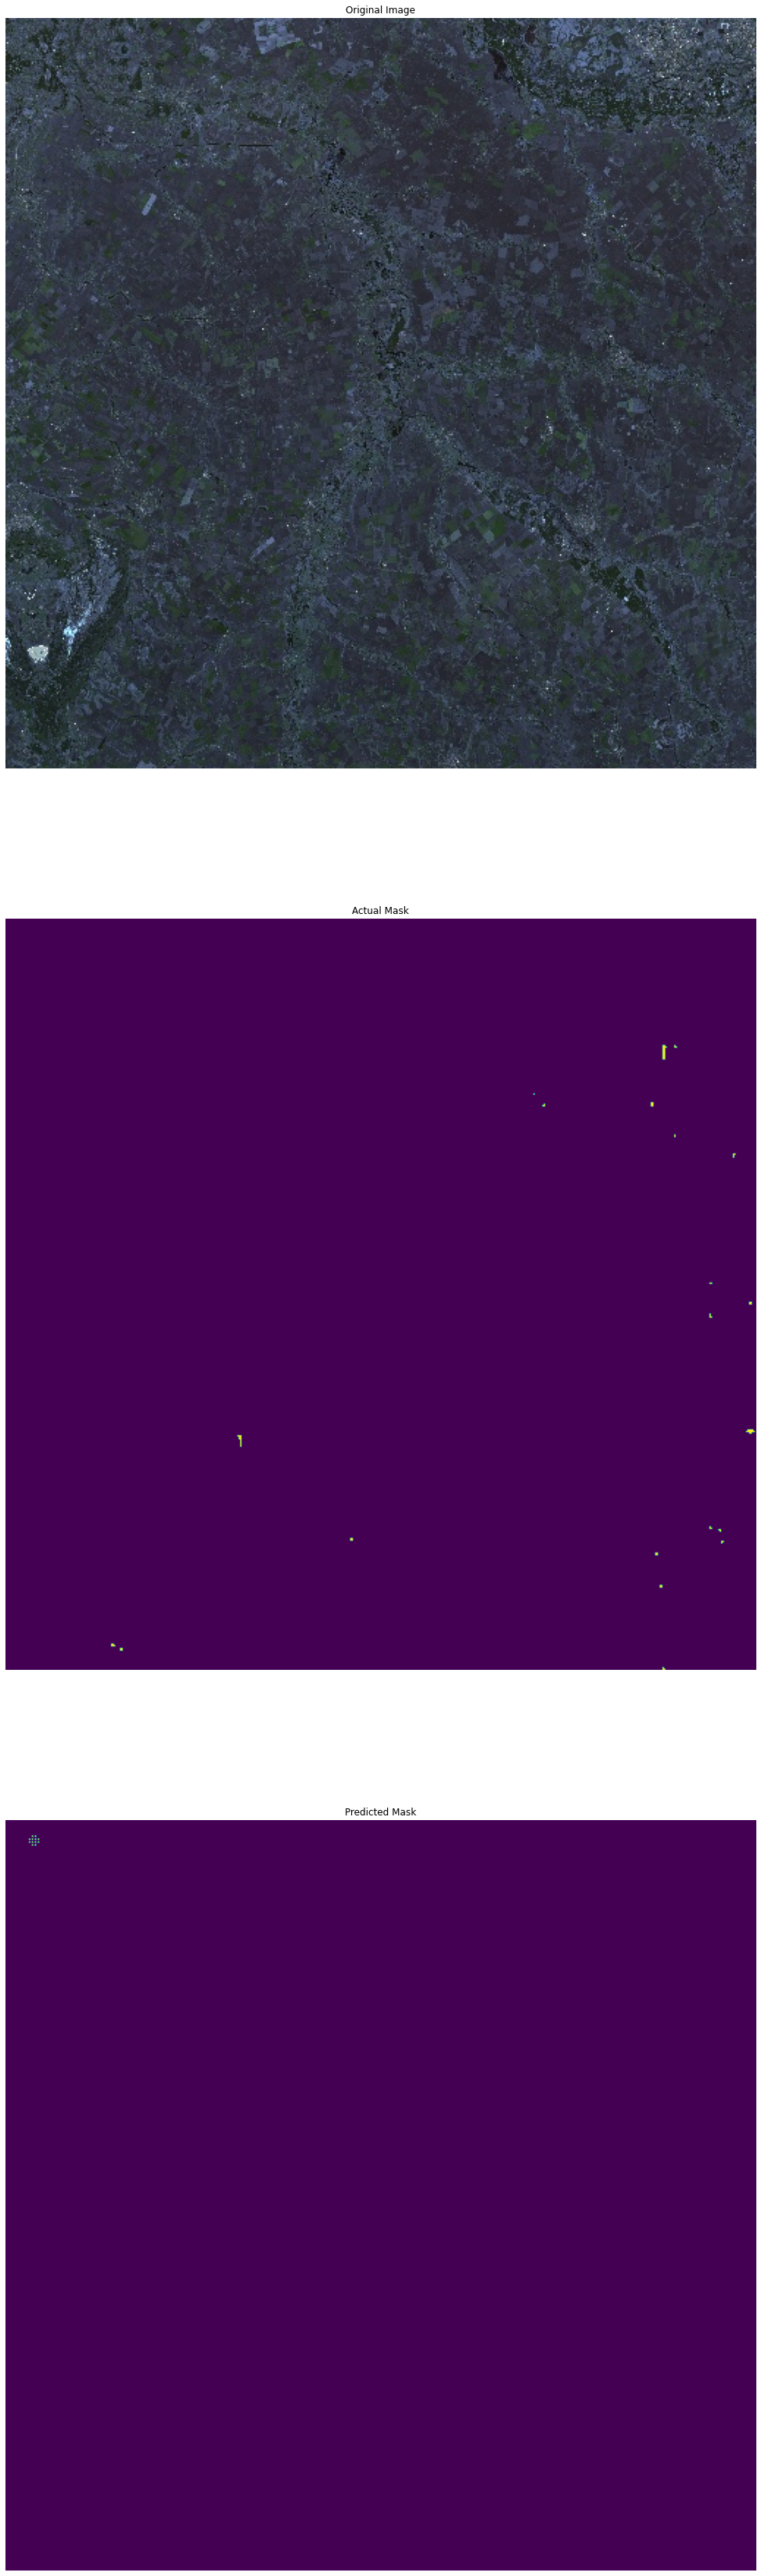

In [75]:
f, axarr = plt.subplots(3,1,figsize=(20, 60))
axarr[0].imshow(val_image_samples)
axarr[0].title.set_text('Original Image')
axarr[0].axis('off')
axarr[1].imshow(val_mask_samples)
axarr[1].title.set_text('Actual Mask')
axarr[1].axis('off')
axarr[2].imshow(predicted_masks)
axarr[2].title.set_text('Predicted Mask')
axarr[2].axis('off')

# Conclusion
* One image training don't give well results
* Accuracy is too optimistic. Calculate mask in one place, because have little amount of 1(positive to soil erosion), that why model predict one point, because error really small(0 model predict too well)
* Using iou_coef make predictions more pessimistic: because of small areas, model think it is better predict nothing then something